In [1]:
using FundamentalsNumericalComputation
FNC.init_format()

┌ Info: verify download of index files...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:139
┌ Info: reading database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:23
┌ Info: adding metadata...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:67
┌ Info: adding svd data...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:69
┌ Info: writing database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:74
┌ Info: used remote sites are sparse.tamu.edu with MAT index and math.nist.gov with HTML index
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:141


(section-bvp-shooting)=
# Shooting

One way to attack the TPBVP {eq}`tpbvp` is to adapt our IVP solving techniques from [Chapter 6](../ivp/overview.md) to it. Those techniques work only when we know the entire initial state, but we can allow that state to vary in order to achieve the stated conditions. 

This is the idea behind the **shooting method**. Imagine adjusting your aiming point and power to sink a basketball shot from the free-throw line. The way in which you miss—too long, flat trajectory, etc.—informs how you will adjust for your next attempt.

(demo-shooting-naive)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

::::{panels}
:column: col-7 left-side
:card: border-0 shadow-none
```{raw} latex
\begin{minipage}[t]{0.5\textwidth}
```
Let's first examine the shooting approach for the TPBVP from {numref}`Example {number} <example-tpbvp-mems>` with $\lambda=0.6$. 

```{raw} latex
\end{minipage}\hfill
```
---
:column: col-5 right-side
:card: shadow-none comment
```{raw} latex
\begin{minipage}[t]{0.4\textwidth}\begin{mdframed}[default]\small
```
The character `ϕ` is typed as `\phi`+<kbd>Tab</kbd>. 
```{raw} latex
\end{mdframed}\end{minipage}
```
::::

In [2]:
λ = 0.6
ϕ = (r,w,dwdr) -> λ/w^2 - dwdr/r;

We convert the ODE to a first-order system in order to apply a numerical method. We also have to truncate the domain to avoid division by zero.

In [3]:
f = (y,p,r) -> [ y[2]; ϕ(r,y[1],y[2]) ]
a,b = eps(),1.0;

The BVP specifies $w'(0)=y_2(0)=0$. We can try multiple values for the unknown $w(0)=y_1(0)$ and plot the solutions.

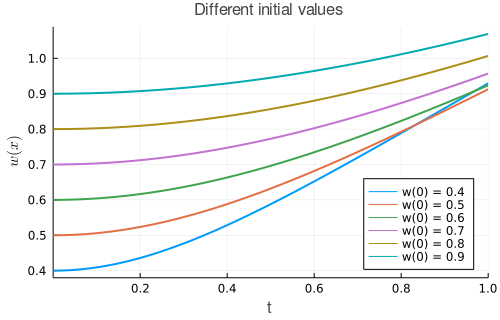

In [4]:
plt = plot(xaxis=(L"x"), yaxis=(L"w(x)"),   
    title="Different initial values",leg=:bottomright)

for w0 in 0.4:0.1:0.9
    IVP = ODEProblem(f,[w0,0],(a,b))
    y = solve(IVP,Tsit5())
    plot!(y,vars=[1],label="w(0) = $w0")
end
plt

On the graph, it's the curve starting at $w(0)=0.8$ that comes closest to the required condition $w(1)=1$, but it's a bit too large.

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

We can do much better than trial-and-error for the unknown part of the initial state. As usual, we can rewrite the ODE $u''(x) = \phi(x,u,u')$ in first-order form as

:::{math}
:label: shoot-first
y_1'&=y_2,\\ 
y_2'&=\phi(x,y_1,y_2).
:::

We turn this into an IVP by specifying $y(a)=s_1$, $y'(a)=s_2$, for a vector $\mathbf{s}$ to be determined by the boundary conditions. Define the residual function $\mathbf{v}(\mathbf{s})$ by

:::{math}
:label: shoot-resid
v_1(s_1,s_2) &= g_1(y_1(a),y_2(a)) = g_1(s_1,s_2),\\ 
v_2(s_1,s_2) &= g_2(y_1(b),y_2(b)).
:::

The dependence of $v_2$ on $\mathbf{s}$ is indirect, through the solution of the IVP for $\mathbf{y}(x)$. We now have a standard rootfinding problem that can be solved via the methods of [Chapter 4](../nonlineqn/overview.md). 

## Implementation

Our implementation of shooting is given in {numref}`Function {number} <function-shoot>`. Note the structure: we use a rootfinding method that in turn relies on an IVP solver. This sort of arrangement is what makes us concerned with minimizing the number of objective function calls when rootfinding.

(function-shoot)=
````{proof:function} shoot
**Shooting method for a two-point boundary-value problem**
```{code-block} julia1
:lineno-start: 1
"""
    shoot(ϕ,xspan,g₁,g₂,init)

Shooting method to solve a two-point boundary value problem with
ODE u'' = `ϕ`(x,u,u') for x in `xspan`, left boundary condition 
`g₁`(u,u')=0, and right boundary condition `g₂`(u,u')=0. The
value `init` is an initial estimate for vector [u,u'] at x=a.

Returns vectors for the nodes, the solution u, and derivative u'.
"""
function shoot(ϕ,xspan,g₁,g₂,init,tol=1e-5)
    # ODE posed as a first-order equation in 2 variables.
    shootivp = (v,p,x) -> [ v[2]; ϕ(x,v[1],v[2]) ]

    # Evaluate the difference between computed and target values at x=b.
    function objective(s)
        IVP = ODEProblem(shootivp,s,float.(xspan))
        sol = solve(IVP,Tsit5(),abstol=tol/10,reltol=tol/10)
        x = sol.t;  y = sol;
        return [g₁(s...),g₂(y[end]...)]
    end

    # Find the unknown quantity at x=a by rootfinding.
    x = [];  y = [];   # these values will be overwritten
    s = levenberg(objective,init,xtol=tol)[:,end]

    # Use the stored last solution of the IVP. 
    u,du_dx = eachrow(y) 
    return x,u,du_dx
end
```
````

::::{admonition} About the code
:class: dropdown
Because `x` and `y` are assigned empty values in line 24, when the function `objective` runs it uses those values rather than new ones in local scope. Thus, line 19 updates them to hold the latest results of the IVP solver, saving the need to solve it again after `levenberg` has finished the rootfinding. 

The error tolerance in the IVP solver is kept smaller than in the rootfinder, to prevent the rootfinder from searching in a noisy landscape. Finally, note how line 28 uses destructuring of `eachrow(y)` to assign the columns of `y` to separate names.
::::

(demo-shooting-mems)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

We revisit {numref}`Demo {number} <demo-shooting-naive>` but let {numref}`Function {number} <function-shoot>` do the heavy lifting.

In [5]:
λ = 0.6
ϕ = (r,w,dwdr) -> λ/w^2 - dwdr/r;
a = eps();  b = 1;

We specify the given and unknown endpoint values.

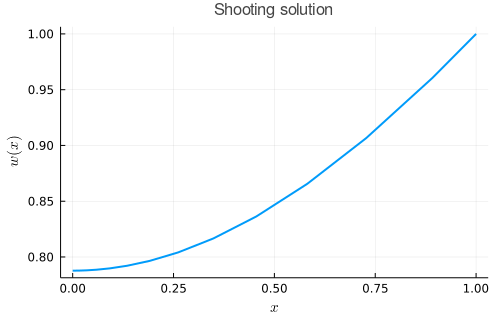

In [6]:
g₁(w,dw) = dw     # w'=0 at left
g₂(w,dw) = w-1    # w=1 at right

r,w,dw_dx = FNC.shoot(ϕ,(a,b),g₁,g₂,[0.8,0])
plot(r,w,title="Shooting solution",
    xaxis=(L"x"), yaxis=(L"w(x)"))

The value of $w$ at $r=1$, meant to be exactly one, was computed to be

In [7]:
@show w[end];

w[end] = 0.999999999795244


The accuracy is consistent with the error tolerance used for the IVP solution. The initial value $w(0)$ that gave this solution is

In [8]:
@show w[1];

w[1] = 0.7877576399197357


```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

## Instability

The accuracy of the shooting method should be comparable to those of the component pieces, the rootfinder, and the IVP solver. However, the shooting method is unstable for some problems. An example illustrates the trouble.

(demo-shooting-unstable)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

We solve the problem
  
$$
u'' = \lambda^2 u + \lambda^2, \quad 0\le x \le 1, \quad u(0)=-1,\; u(1)=0.
$$

The exact solution is easily confirmed to be

$$
u(x) = \frac{\sinh(\lambda x)}{\sinh(\lambda)} - 1.
$$

This solution satisfies $-1\le u(x) \le 0$ for all $x\in[0,1]$. Now we compute shooting solutions for several values of $\lambda$.

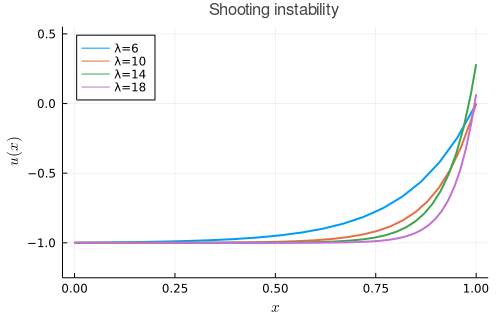

In [9]:
plt = plot(xaxis=(L"x"),yaxis=([-1.2,0.5],L"u(x)"),
    title="Shooting instability",leg=:topleft)
for λ in 6:4:18
    g₁(u,du) = u+1
    g₂(u,du) = u
    ϕ = (x,u,du_dx) -> λ^2*(u + 1)
    x,u = FNC.shoot(ϕ,(0.0,1.0),g₁,g₂,[-1,0])
    plot!(x,u,label="λ=$λ")
end
plt

The numerical solutions evidently don't satisfy the right boundary condition as $\lambda$ increases, which makes them invalid. 

The cause is readily explained. The solution to the ODE with $u(0)=-1$ and $u'(0)=s_2$  is

:::{math}
  :label: shootinstabshoot
    \frac{s_2}{\lambda}\sinh(\lambda x) - 1.
:::

If $x$ is a fixed value in $[0,1]$, we compute that the absolute condition number of {eq}`shootinstabshoot` with respect to $s_2$ is the magnitude of the partial derivative,

$$
  \left| \frac{\sinh\lambda x}{\lambda} \right|,
$$

which grows rapidly with $\lambda$ near $x=1$. With the IVP solution so sensitive to $s_2$, a numerical approach to find $s_2$ approximately is doomed.

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

The essence of the instability is that errors can grow exponentially away from the boundary at $x=a$, where the state is arbitrarily being set (see {numref}`Theorem {number} <theorem-depIC>`). Using shooting, acceptable accuracy near $x=b$ therefore means requiring extraordinarily high accuracy near $x=a$.

The instability of shooting can be circumvented by breaking the interval into smaller pieces and thus limiting the potential for error growth. However, we do not go into these details. Instead, the methods in the rest of this chapter treat both ends of the domain symmetrically and solve over the whole domain at once.

## Exercises

1. ⌨ For each BVP in [Exercise 10.1.2](problem-tpbvp-verify) , use {numref}`Function {number} <function-shoot>` to compute the solution. Plot the solution and, separately, its error as functions of $x$. 

    ```{index} pendulum
    ```
    (problem-shooting-pendulum)=
2. ⌨ (Continuation of [Exercise 10.1.4](problem-tpbvp-allencahn).) Consider the pendulum from {numref}`Example {number} <example-tpbvp-pendulum>` with $g=L=1$. Suppose we want to release the pendulum from rest such that $\theta(5)=\pi/2$. Find one solution that passes through $\theta=0$, and another solution that does not. Plot $\theta(t)$ for both cases together.

    ```{index} Allen–Cahn equation
    ```
    (problem-shooting-allencahn)=
3. ⌨  (Continuation of [Exercise 10.1.5](problem-tpbvp-allencahn).) The stationary Allen–Cahn equation is 
 
    $$
      \epsilon u'' = u^3-u, \qquad 0 \le x \le 1, \qquad u(0)=-1, \quad u(1)=1.
    $$

    As $\epsilon\rightarrow 0$, the solution tends toward a step function transition between $-1$ and $1$. By symmetry, $u'(x)=-u'(1-x)$.
  
    **(a)** Use {numref}`Function {number} <function-shoot>` to solve the equation for $\epsilon=0.2$. Plot the solution and compute the numerical value of $u'(0)-u'(1)$.
    
    **(b)** Repeat for $\epsilon=0.02$.
    
    **(c)** Repeat for $\epsilon=0.002$. You will receive multiple warning messages. Does the result look like a valid solution?

4. ✍ Consider the linear TPBVP 
    
    $$
    \begin{split}
    u'' &= p(x)u' + q(x)u + r(x),\\ 
    u'(a) &= 0, \quad u(b)=\beta.
    \end{split}
    $$

    The shooting IVP uses the same ODE with initial data $u(a)=s_1$, $u'(a)=s_2$ to solve for a trial solution $u(x)$. Define

    $$
    z(x) = \frac{\partial u}{\partial s_1}.
    $$

    By differentiating the IVP with respect to $s_1$, show that $z$ satisfies the IVP

    $$
    z'' = p(x)z' + q(x)z, \quad z(0)=1, \; z'(0)=0.
    $$

    It follows that $z(x)$ is independent of $s_1$, and therefore $u(x)$ is a linear function of $s_1$ at each fixed $x$. Use the same type of argument to show that $u(x)$ is also a linear function of $s_2$, and explain why the residual function $\mathbf{v}$ in {eq}`shoot-resid` is a linear function of $\mathbf{s}$.